In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib
import itertools as it
import matplotlib.pyplot as plt
import venn
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
# get combos that contain genes which can cause both high and low bmi
combo2_file = "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/white_british/data/parsed_tables/combo_2.csv"
combo3_file = "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/white_british/data/parsed_tables/combo_3.csv"

icd_risk_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/obesity_related_diseases/data/merged_combos/risk_combos.csv"
icd_protection_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/obesity_related_diseases/data/merged_combos/protective_combos.csv"

In [4]:
def parse_combo_df(combo2_file, combo3_file):
    combo2_df = pd.read_csv(combo2_file, usecols=["Phenotype", "Item_1", "Item_2", "Item_1_symbol", "Item_2_symbol", "Case_Samples"])
    combo2_df["Item_3"] = np.nan
    combo2_df["Item_3_symbol"] = np.nan
    combo3_df = pd.read_csv(combo3_file, usecols=["Phenotype", "Item_1", "Item_2", "Item_3", "Item_1_symbol", "Item_2_symbol", "Item_3_symbol", "Case_Samples"])
    combo_df = pd.concat((combo2_df, combo3_df))
    return combo_df.loc[:, ["Phenotype", "Item_1", "Item_2", "Item_3", "Item_1_symbol", "Item_2_symbol", "Item_3_symbol", "Case_Samples"]].reset_index(drop=True)

def get_combos_from_df(df):
    combos = sorted(map(lambda x: tuple(sorted([i for i in x if not pd.isnull(i)])), zip(*[df[f"Item_{c}_symbol"].to_list() for c in range(1, 3+1)])))
    return set(combos)

In [5]:
high_bmi_df = parse_combo_df(combo2_file, combo3_file)
icd_risk_df = pd.read_csv(icd_risk_file)
icd_protection_df = pd.read_csv(icd_protection_file)

In [6]:
high_bmi_combos = get_combos_from_df(high_bmi_df)
icd_risk_combos = get_combos_from_df(icd_risk_df)
icd_protection_combos = get_combos_from_df(icd_protection_df)

In [7]:
venn_dict = dict()

def set_add(a, b):
    return a.intersection(b)

def set_subtract(a,b):
    return a.difference(b)

def get_intersecting_genes_num(gene_sets, prod):
    sign = [-1 if p==0 else 1 for p in prod]
    sign_dict = {idx: s for idx,s in zip(range(len(prod)), sign)}
    # get the positive signs first
    sign_dict = dict(sorted(sign_dict.items(), key=lambda item:item[1], reverse=True))
    for i, (k,v) in enumerate(sign_dict.items()):
        if i == 0:
            assert v==1
            final_set = gene_sets[k]
        else:
            if v==-1:
                final_set = set_subtract(final_set, gene_sets[k])
            else:
                assert v==1
                final_set = set_add(final_set, gene_sets[k])
    return len(final_set)

for prod in list(it.product([0, 1], repeat=3)):
    if all(p == 0 for p in prod):
        continue
    else:
        venn_dict["".join(list(map(str, prod)))] = get_intersecting_genes_num([high_bmi_combos,  icd_risk_combos, icd_protection_combos], prod)


In [8]:
venn_dict

{'001': 294, '010': 107, '011': 1, '100': 83, '101': 7, '110': 0, '111': 0}

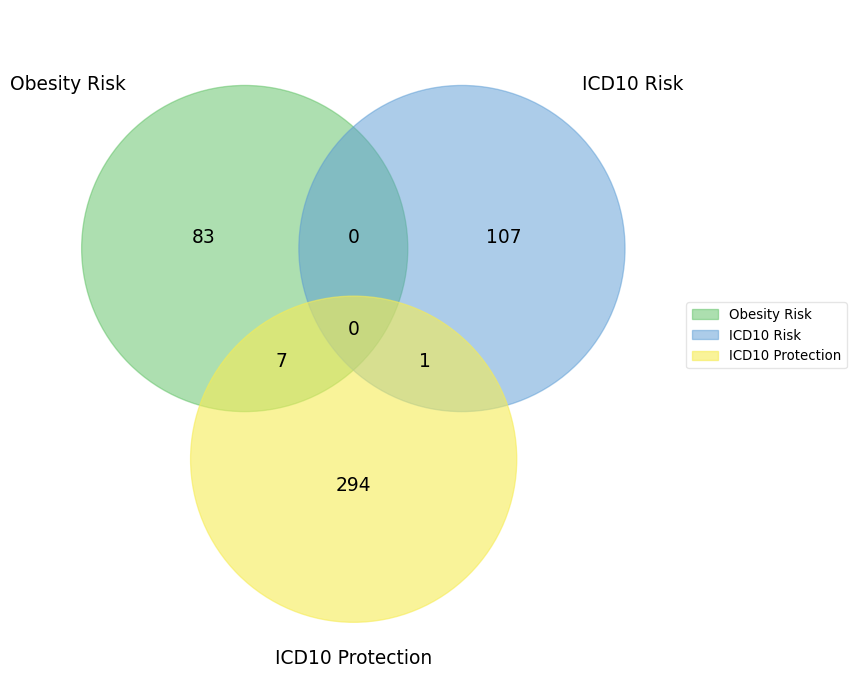

In [9]:
fig, ax = venn.venn3(venn_dict, names=["Obesity Risk", "ICD10 Risk", "ICD10 Protection"])
fig.show()

In [10]:
icd_risk_combos.intersection(icd_protection_combos)

{('BTD', 'CFTR', 'TTN')}

In [11]:
def get_gene_specific_combo_info(df, gene):
    df = df.loc[(df.Item_1_symbol==gene)|((df.Item_2_symbol==gene))|((df.Item_3_symbol==gene))].reset_index(drop=True)
    return df

def get_case_samples(df):
    high_pheno_cases = ",".join(df.loc[df.Phenotype=="high_bmi"].Case_Samples.str.strip('"').values.flatten()).split(",")
    low_pheno_cases = ",".join(df.loc[df.Phenotype=="low_bmi"].Case_Samples.str.strip('"').values.flatten()).split(",")
    return high_pheno_cases, low_pheno_cases


In [12]:
get_gene_specific_combo_info(icd_protection_df, "BTD")

,Phenotype,Item_1_symbol,Item_2_symbol,Item_1,Item_2,Case_Obs_Count_I1,Case_Obs_Count_I2,Case_Exp_Prob_Combo,Case_Obs_Prob_Combo,Case_Exp_Count_Combo,...,Effect_Size,Power_One_Pct,Power_Five_Pct,Fail_Power,Case_Samples,Control_Samples,Item_3_symbol,Item_3,Case_Obs_Count_I3,Cont_Obs_Count_I3
0,BlockM15-M19,CFTR,TTN,ENSG00000001626,ENSG00000155657,1368,2117,0.000034,0.000305,0.88,...,0.034917,0.513,0.741,False,"1127149,1942448,2144431,2601852,4644532,517880...",NaN,BTD,ENSG00000169814,210.0,57.0


In [16]:
get_gene_specific_combo_info(icd_risk_df, "CHD6")

,Phenotype,Item_1_symbol,Item_2_symbol,Item_1,Item_2,Case_Obs_Count_I1,Case_Obs_Count_I2,Case_Exp_Prob_Combo,Case_Obs_Prob_Combo,Case_Exp_Count_Combo,...,Effect_Size,Power_One_Pct,Power_Five_Pct,Fail_Power,Case_Samples,Control_Samples,Item_3_symbol,Item_3,Case_Obs_Count_I3,Cont_Obs_Count_I3
0,R074,CHD6,SUZ12,ENSG00000124177,ENSG00000178691,36,25,0.000112,0.002465,0.32,...,0.076426,0.907,0.974,False,"3074320,3358846,3445407,3628551,4430438,544053...","1797857,3965027,4213469,4983444",NaN,NaN,NaN,NaN
1,I251,CHD6,SUZ12,ENSG00000124177,ENSG00000178691,33,18,0.000137,0.002397,0.28,...,0.070239,0.702,0.874,False,"3358846,3445407,4430438,4983444,5440532","1797857,3074320,3628551,3965027,4213469,5712102",NaN,NaN,NaN,NaN


In [15]:
get_gene_specific_combo_info(icd_risk_df, "CHD6").Case_Samples.values

array(['3074320,3358846,3445407,3628551,4430438,5440532,5712102',
       '3358846,3445407,4430438,4983444,5440532'], dtype=object)

In [17]:
get_gene_specific_combo_info(icd_risk_df, "CHD6").Control_Samples.values

array(['1797857,3965027,4213469,4983444',
       '1797857,3074320,3628551,3965027,4213469,5712102'], dtype=object)